In [0]:
import os
from glob import glob
os.chdir('/content/')
!rm -rf Satellite-Segmentation
!git clone https://github.com/JasonChu1313/Satellite-Segmentation.git
import os 
os.chdir('/content/Satellite-Segmentation')
!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/
!kaggle competitions download -c comp-540-spring-2019
!mkdir data
!mv train.zip ./data/
!mv val.zip ./data/
os.chdir("/content/Satellite-Segmentation/data")
!unzip val.zip
!unzip train.zip
os.chdir("./train")

In [0]:
import os
from glob import glob
os.chdir("/content/Satellite-Segmentation/data/train")

!ls

In [3]:
glob_train_imgs = '*_sat.jpg'
glob_train_masks = '*_msk.png'
train_img_paths = glob(glob_train_imgs)
train_mask_paths = glob(glob_train_masks)
print(train_img_paths[:10])
print(train_mask_paths[:10])

['36300_sat.jpg', '36829_sat.jpg', '17476_sat.jpg', '18661_sat.jpg', '31117_sat.jpg', '19482_sat.jpg', '21204_sat.jpg', '18185_sat.jpg', '1252_sat.jpg', '29946_sat.jpg']
['33005_msk.png', '52944_msk.png', '32440_msk.png', '19350_msk.png', '46321_msk.png', '10704_msk.png', '13495_msk.png', '14680_msk.png', '53473_msk.png', '52358_msk.png']


In [0]:
from skimage.io import imread
from skimage.transform import resize
# This will be useful so we can construct the corresponding mask
def get_img_id(img_path):
    img_basename = os.path.basename(img_path)
    img_id = os.path.splitext(img_basename)[0][:-len('_sat')]
    return img_id

# Write it like a normal function
def image_gen(img_paths, img_size=(512, 512), gen_mask = True):
    # Iterate over all the image paths
    for img_path in img_paths:
        
        # Construct the corresponding mask path
        img_id = get_img_id(img_path)
        mask_path = os.path.join(img_id + '_msk.png')
        
        # Load the image and mask, and normalize it to 0-1 range
        color_img = imread(img_path)
        
        gray_img = color_img / 255.
        
        
        
        # Resize the images
        color_img = resize(color_img, img_size, preserve_range=True)
        gray_img = resize(gray_img, img_size, preserve_range=True)
        
        if gen_mask:
          mask = imread(mask_path, as_gray=True)
          mask = resize(mask, img_size, mode='constant', preserve_range=True)
          # Turn the mask back into a 0-1 mask
          mask = (mask >= 0.5).astype(float)
        else:
          mask = []

        # Yield the image mask pair
        yield gray_img, mask

# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    """
    x = numpyarray of size (height, width) representing the mask of an image
    if x[i,j] == 0:
        image[i,j] is not a road pixel
    if x[i,j] != 0:
        image[i,j] is a road pixel
    """
    dots = np.where(x.T.flatten() != 0)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): 
            run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


the shape of training image is (512, 512, 3) 
the shape of mask image is (512, 512, 3)


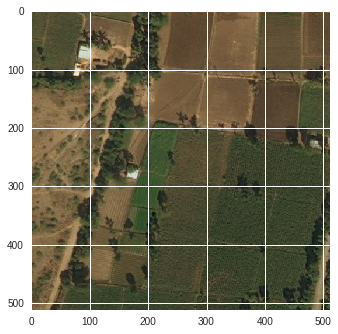

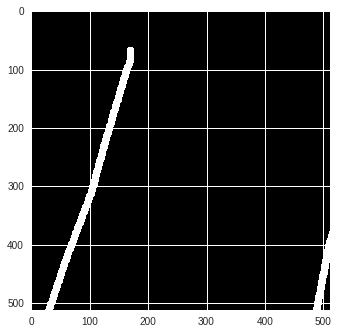

In [5]:
import matplotlib.pyplot as plt
import numpy as np
ig = image_gen(train_img_paths)
train_img, train_mask = next(ig)

print("the shape of training image is {} ".format(train_img.shape))
print("the shape of mask image is {}".format(train_mask.shape))

plt.imshow(train_img)
plt.show()
plt.imshow(train_mask, cmap='gray')
plt.show()

In [6]:
print("number of training image is {}".format(len(train_img_paths)))

number of training image is 10897


In [13]:
# 1. encode all the training image to Run-length
# 2. compute in training set and test set the distribution of road pixels
# 3. compute in training set and test set the comparision between black and white pixels in mask
# 4. compute the distribution of black pixels as several times the number of white pixels
import pandas as pd
import numpy as np
ig = image_gen(train_img_paths)
train_mask = pd.DataFrame(columns=['ImageId','EncodedPixels'])
total_num = 512*512
# black pixels as several times the number of white pixels
b_to_w = []
map_r_road = {}
map_g_road = {}
map_b_road = {}


for i in range(len(train_img_paths)):
    train_img, train_mask = next(ig)
    dots = np.where(train_mask[:,:,0].T.flatten()!=0)[0]
    # number of white pixels in image
    num_w = len(dots)
    # number of black pixels in image
    num_b = total_num - num_w
    
    if(num_w == 0):
        b_to_w.append(total_num+1)
    else:
        b_to_w.append(num_b/num_w)
    
    # compute the distribution of the each value in road pixel
    r = train_img[:,:,0].T.flatten()
    g = train_img[:,:,1].T.flatten()
    b = train_img[:,:,2].T.flatten()
    
    if j in dots:
        if r[j] in map_r_road:
          map_r_road[r[j]] = map_r_road[r[j]] + 1
        else:
          map_r_road[r[j]] = 1

        if g[j] in map_g_road:
          map_g_road[g[j]] = map_g_road[g[j]] + 1
        else:
          map_g_road[g[j]] = 1

        if b[j] in map_b_road:
          map_b_road[b[j]] = map_b_road[b[j]] + 1
        else:
          map_b_road[b[j]] = 1
      
      
    if i%1000 == 0:
      print('process {}th image'.format(i))
          


process 0th image
process 1000th image
process 2000th image
process 3000th image
process 4000th image
process 5000th image
process 6000th image
process 7000th image
process 8000th image
process 9000th image
process 10000th image


(array([9.012e+03, 1.600e+01, 9.000e+00, 6.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 3.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.841e+03]),
 array([1.00000000e+00, 8.73913333e+03, 1.74772667e+04, 2.62154000e+04,
        3.49535333e+04, 4.36916667e+04, 5.24298000e+04, 6.11679333e+04,
        6.99060667e+04, 7.86442000e+04, 8.73823333e+04, 9.61204667e+04,
        1.04858600e+05, 1.13596733e+05, 1.22334867e+05, 1.31073000e+05,
        1.39811133e+05, 1.48549267e+05, 1.57287400e+05, 1.66025533e+05,
        1.74763667e+05, 1.83501800e+05, 1.92239933e+05, 2.00978067e+05,
        2.09716200e+05, 2.18454333e+05, 2.27192467e+05, 2.35930600e+05,
        2.44668733e+05, 2.53406867e+05, 2.62145000e+05]),
 <a list of 30 Patch objects>)

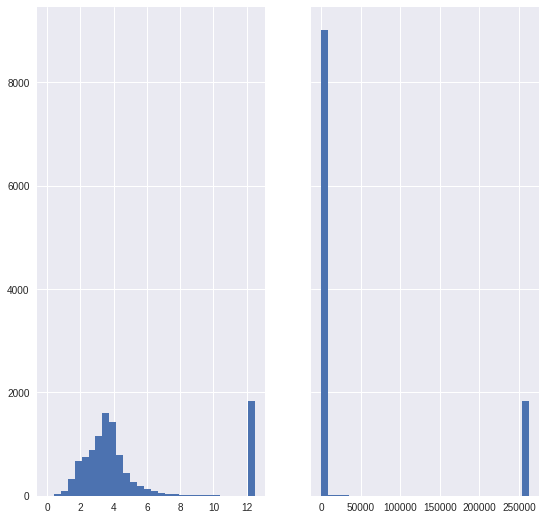

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(9,9))
x=np.log(b_to_w)
ax1.hist(x, bins=30)
ax2.hist(b_to_w, bins=30)

In [0]:
def image_stat(img):
  dims = np.shape(img)
  print(dims)

  pixel_matrix = np.reshape(img, (dims[0] * dims[1], dims[2]))

  # show correlationship of each channel
  f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

  ax1.set_title("correlationship of the r and g")
  _ = ax1.scatter(pixel_matrix[:,0], pixel_matrix[:,1])
  ax2.set_title("correlationship of the g and b")
  _ = ax2.scatter(pixel_matrix[:,1], pixel_matrix[:,2])
  ax3.set_title("correlationship of the r and b")
  _ = ax3.scatter(pixel_matrix[:,0], pixel_matrix[:,2])

  # show histogram of each channel
  f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
  ax1.set_title("histogram of r")
  ax1.hist(pixel_matrix[:,0].ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k') #calculating histogram
  ax2.set_title("histogram of g")
  ax2.hist(pixel_matrix[:,1].ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
  ax3.set_title("histogram of b")
  ax3.hist(pixel_matrix[:,2].ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k') 

In [0]:
b_to_w
# 1,2,5
# 3,4,6

(512, 512, 3)


0.0

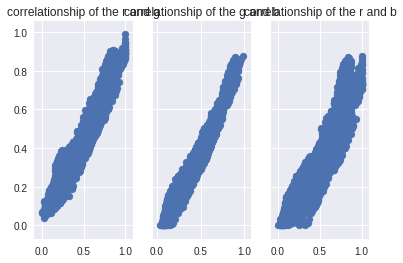

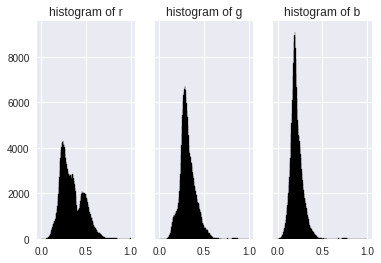

In [64]:
# simple k means clustering
from sklearn import cluster
from mpl_toolkits.mplot3d import Axes3D
# For non-outlier
ig = image_gen(train_img_paths)
train_img, train_mask = next(ig)
image_stat(train_img)
np.min(train_mask)

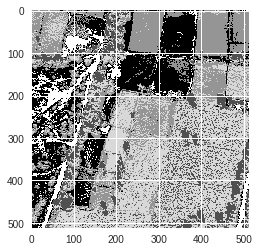

In [65]:
pixel_matrix = np.reshape(train_img, (dims[0] * dims[1], dims[2]))

kmeans = cluster.KMeans(5)
clustered = kmeans.fit_predict(pixel_matrix)

clustered_img = np.reshape(clustered, (dims[0], dims[1]))
plt.imshow(clustered_img)

Text(0.5,0,'Red channel')

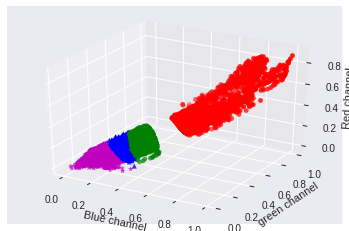

In [66]:
ind0, ind1, ind2, ind3 = [np.where(clustered == x)[0] for x in [0, 1, 2, 3]]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plot_vals = [('r', 'o', ind0),
             ('b', '^', ind1),
             ('g', '8', ind2),
             ('m', '*', ind3)]

for c, m, ind in plot_vals:
    xs = pixel_matrix[ind, 0]
    ys = pixel_matrix[ind, 1]
    zs = pixel_matrix[ind, 2]
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('Blue channel')
ax.set_ylabel('green channel')
ax.set_zlabel('Red channel')

(512, 512, 3)


0.0

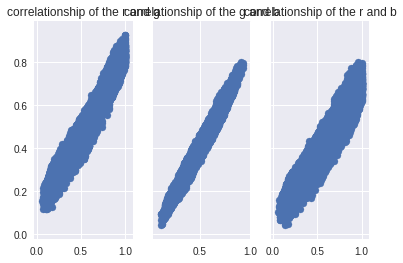

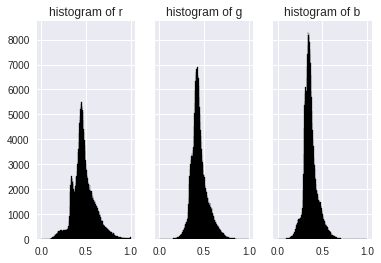

In [62]:
# For non-outlier
ig = image_gen(train_img_paths)
next(ig)
next(ig)
next(ig)
next(ig)
train_img, train_mask = next(ig)
image_stat(train_img)
np.min(train_mask)

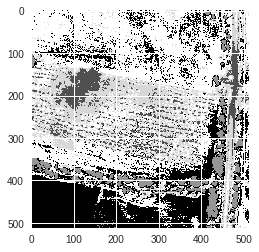

In [63]:
pixel_matrix = np.reshape(train_img, (dims[0] * dims[1], dims[2]))

kmeans = cluster.KMeans(5)
clustered = kmeans.fit_predict(pixel_matrix)

clustered_img = np.reshape(clustered, (dims[0], dims[1]))
plt.imshow(clustered_img)

(512, 512, 3)


0.0

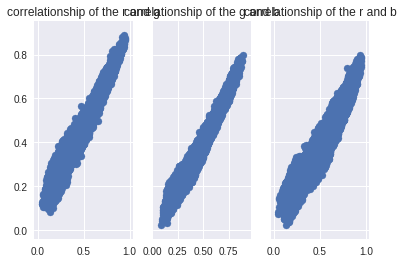

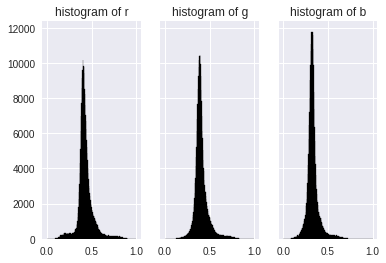

In [52]:
# For non-outlier
ig = image_gen(train_img_paths)
next(ig)
train_img, train_mask = next(ig)
image_stat(train_img)
np.min(train_mask)

(512, 512, 3)


0.0

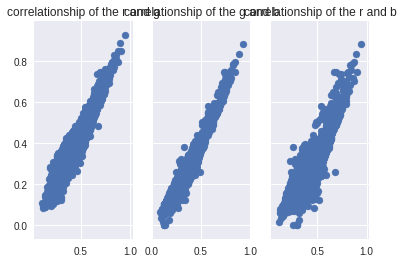

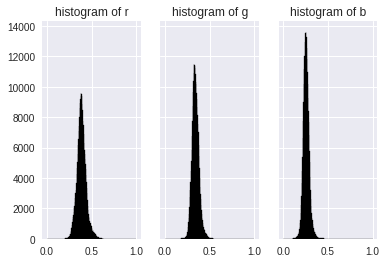

In [56]:
# For outlier data
ig = image_gen(train_img_paths)
next(ig)
next(ig)
train_img_outlier, train_mask_outlier = next(ig)
image_stat(train_img_outlier)
np.max(train_mask_outlier)

(512, 512, 3)


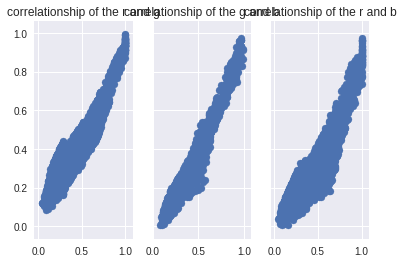

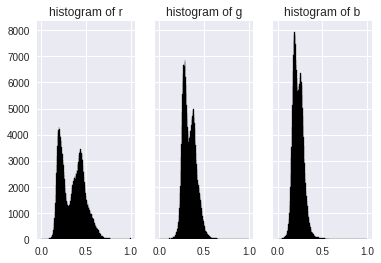

In [54]:
# For outlier data
ig = image_gen(train_img_paths)
next(ig)
next(ig)
next(ig)
train_img_outlier, train_mask_outlier = next(ig)
image_stat(train_img_outlier)

(512, 512, 3)


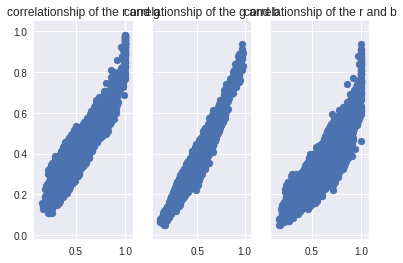

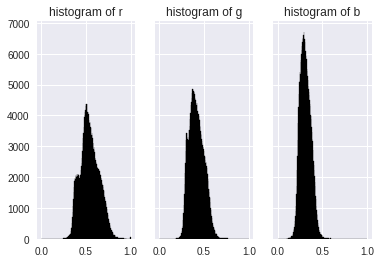

In [55]:
# For outlier data
ig = image_gen(train_img_paths)
next(ig)
next(ig)
next(ig)
next(ig)
next(ig)
train_img_outlier, train_mask_outlier = next(ig)
image_stat(train_img_outlier)

In [17]:
print("num of outlier = {}".format(b_to_w.count(262145)))

count = 0
for i in range(10000):
  count = count + b_to_w.count(262145-i)
print("num of outlier (with 10000 margin) = {}".format(count))

num of outlier = 1838
num of outlier (with 10000 margin) = 1841


In [18]:
print("mean of black to white {}".format(np.mean(b_to_w)))
print("min of black to white {}".format(np.min(b_to_w)))
print("max of black to white {}".format(np.max(b_to_w)))

map_r_sorted_road = sorted(map_r_road.items(), key=lambda s: s[0])
map_g_sorted_road = sorted(map_g_road.items(), key=lambda s: s[0])
map_b_sorted_road = sorted(map_b_road.items(), key=lambda s: s[0])

map_r_sorted_bg = sorted(map_r_bg.items(), key=lambda s: s[0])
map_g_sorted_bg = sorted(map_g_bg.items(), key=lambda s: s[0])
map_b_sorted_bg = sorted(map_b_bg.items(), key=lambda s: s[0])

mean of black to white 44521.2556667
min of black to white 1
max of black to white 262145


In [0]:
new_map_r = {}
new_map_g = {}
new_map_b = {}

current_index = 0
for i in range(1,21):
  new_map_r[0.05 * i] = 0
  while current_index < len(map_r) and map_r[current_index][0] <= (0.05 * i):
    new_map_r[0.05 * i] += map_r[current_index][1]
    current_index+=1

    
current_index = 0
for i in range(1,21):
  new_map_g[0.05 * i] = 0
  while current_index < len(map_g) and map_g[current_index][0] <= (0.05 * i):
    new_map_g[0.05 * i] += map_g[current_index][1]
    current_index+=1
    
current_index = 0
for i in range(1,21):
  new_map_b[0.05 * i] = 0
  while current_index < len(map_b) and map_b[current_index][0] <= (0.05 * i):
    new_map_b[0.05 * i] += map_b[current_index][1]
    current_index+=1

{0.25: 3923373, 0.5: 15125153, 1.0: 206383, 0.1: 262554, 0.2: 2269539, 0.8500000000000001: 1463227, 0.4: 10151923, 0.15000000000000002: 1085366, 0.8: 2115550, 0.30000000000000004: 5649665, 0.05: 28407, 0.9: 920453, 0.9500000000000001: 404823, 0.75: 3601296, 0.45: 12855251, 0.6000000000000001: 11805568, 0.7000000000000001: 6019573, 0.35000000000000003: 7799002, 0.55: 14667248, 0.65: 8504882}


<BarContainer object of 20 artists>

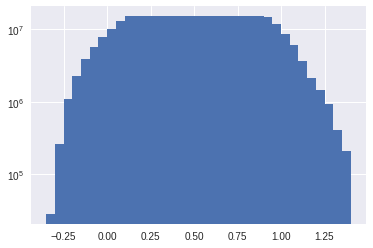

In [60]:
print(new_map_r)
plt.bar(new_map_r.keys(), new_map_r.values(), log = True)

{0.25: 4037726, 0.5: 17714283, 1.0: 73442, 0.1: 251293, 0.2: 2283573, 0.8500000000000001: 461640, 0.4: 14026928, 0.15000000000000002: 1084120, 0.8: 902614, 0.30000000000000004: 6040907, 0.05: 20665, 0.9: 235529, 0.9500000000000001: 121251, 0.75: 1807587, 0.45: 17445317, 0.6000000000000001: 9385333, 0.7000000000000001: 3456076, 0.35000000000000003: 9698647, 0.55: 14139791, 0.65: 5672514}


<BarContainer object of 20 artists>

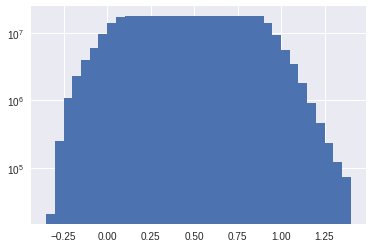

In [61]:
print(new_map_g)
plt.bar(new_map_g.keys(), new_map_g.values(), log = True)

{0.25: 9121140, 0.5: 10381977, 1.0: 25597, 0.1: 835316, 0.2: 5606623, 0.8500000000000001: 108018, 0.4: 17916357, 0.15000000000000002: 2776287, 0.8: 218754, 0.30000000000000004: 14572265, 0.05: 164078, 0.9: 60150, 0.9500000000000001: 39230, 0.75: 452446, 0.45: 13355995, 0.6000000000000001: 3814676, 0.7000000000000001: 945574, 0.35000000000000003: 19698214, 0.55: 6885476, 0.65: 1881063}


<BarContainer object of 20 artists>

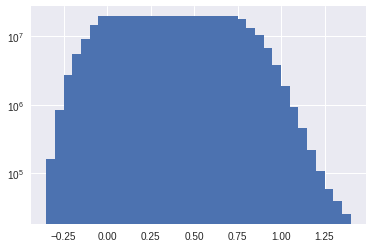

In [62]:
print(new_map_b)
plt.bar(new_map_b.keys(), new_map_b.values(), log = True)

In [63]:
os.chdir("../val")
test_image_path = "*_*_sat.jpg"
test_image_path = glob(test_image_path)
print(test_image_path[:10])

ig = image_gen(test_image_path,gen_mask=False)
test_map_r = {}
test_map_g = {}
test_map_b = {}
for i in range(len(test_image_path)):
    test_img, _ = next(ig)
    
    # compute the distribution of the each value in road pixel
    r = test_img[:,:,0].T.flatten()
    g = test_img[:,:,1].T.flatten()
    b = test_img[:,:,2].T.flatten()
    
    for j in dots:
      
      if r[j] in map_r:
        map_r[r[j]] = map_r[r[j]] + 1
      else:
        map_r[r[j]] = 1
        
      if g[j] in map_g:
        map_g[g[j]] = map_g[g[j]] + 1
      else:
        map_g[g[j]] = 1
       
      if b[j] in map_b:
        map_b[b[j]] = map_b[b[j]] + 1
      else:
        map_b[b[j]] = 1
    if i % 1000 == 0 :
      print('process {}th image'.format(i))


[]
